In [1]:
# Copyright 2019 The Authors. All Rights Reserved.
#
# GNU General Public License v3.0
# Permissions of this strongest copyleft license are conditioned on 
# making available complete source code of licensed works and modifications, 
# which include larger works using a licensed work, under the same license. 
# Copyright and license notices must be preserved. 
# Contributors provide an express grant of patent rights. 
# When a modified version is used to provide a service over a network, 
# the complete source code of the modified version must be made available.
# ==============================================================================

# Title: Clustering of CRISPR spacers using Autoencoders
# Author: Hyunjin Shim
# Date created: 20200207
# Email: jinenstar@gmail.com

# Clustering CRISPR spacers using Autoencoders

- to analyze CRISPR spacers from CRISPR-Cas++
- to cluster CRISPR spacers by type
- to perform dimensionality reduction to identify patterns
- to visualize the results after each experimentation
- to assess the best possible network architecture

# Dataset description
- Total: 221,397 spacers
- Classified: some spacers classified by Type from CRISPR-Cas++ (CRISPR_spacer_data_processing.ipynb)

In [2]:
# Data
import os
from pathlib import Path 
import glob
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple

# Biopython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Regular expression
import re

# Plot
from pylab import *
import pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

# Tensorflow
import tensorflow as tf
from keras.layers import Input, Dense, Masking
from keras.models import Model
from keras.optimizers import Adam, SGD
from tensorflow.keras import layers

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import itertools

# Math
import math
from statistics import mean, stdev


Using TensorFlow backend.


# Step 1: Load and preprocess raw data

In [3]:
# location of raw data file
datapath = Path("/Users/jinenstar/Desktop/Data/CRISPR/CRISPR-Cas++/Spacer/Data_Spacer")
#os.chdir(datapath)

nt_vocab = {"<pad>":0, "T":1, "A":2, "G":3, "C":4, "t":1, "a":2, "g":3, "c":4, "N":0, "n":0, "K":0, "k":0, "Y":0, "y":0, "M":0, "m":0, "R":0, "r":0, "W":0, "w":0, "S":0, "s":0, "H":0, "h":0, "B":0, "b":0, "D":0, "d":0, ".":"", "(":"", ")":""}

def extract_dataset_info(records: List[SeqRecord]) -> Dict: 
    # Contains information on dataset
    seqs_id = [r.id for r in records]
    seqs_len = [len(r.seq) for r in records]
    seqs = [str(r.seq) for r in records]
    int_seqs = [[nt_vocab[nt] for nt in s] for s in seqs]
    d = {"ID":seqs_id, "Seq":seqs, "Int_Seq":int_seqs, "Length":seqs_len}
    return d

def calculate_GC_content(Seq): 
    GC_bySeq = [None] * len(Seq)
    for i in range(len(Seq)):
        T=0; A=0; G=0; C=0
        T = T+Seq[i].count("T")
        A = A+Seq[i].count("A")
        G = G+Seq[i].count("G")
        C = C+Seq[i].count("C")
        if (T+A) != 0:
            GC_bySeq[i] = (G+C)/(T+A)
        else:
            GC_bySeq[i] = NaN
    return nanmean(GC_bySeq), nanstd(GC_bySeq) if len(GC_bySeq) > 1 else None
    
def calculate_Shannon_E(Seq):
    all_Shannon = [None]*len(Seq)
    all_Entropy = [None]*len(Seq)
    
    for i in range(len(Seq)): 
        Seq_len = len(Seq[i])
        f1 = Seq[i].count('T')/Seq_len
        f2 = Seq[i].count('A')/Seq_len
        f3 = Seq[i].count('G')/Seq_len
        f4 = Seq[i].count('C')/Seq_len
        all_Shannon[i] = -((f1*(math.log(f1,2) if f1 != 0 else 0)) + (f2*(math.log(f2,2) if f2 != 0 else 0)) + (f3*(math.log(f3,2) if f3 != 0 else 0)) + (f4*(math.log(f4,2) if f4 != 0 else 0)))
        all_Entropy[i] = all_Shannon[i]/Seq_len
    return mean(all_Entropy), stdev(all_Entropy) if len(all_Entropy) > 1 else None

def calculate_cluster_mean(cluster):
    return mean(cluster["length"])

def calculate_cluster_stdev(cluster):
    return stdev(cluster["length"])

In [4]:
spacer_data = {"train": None, "test": {}}
spacer_data_info = {"train": None, "test": {}}

# Load train sequences
train_path = datapath / Path("20190618_spacer_34.fasta")
records = list(SeqIO.parse(str(train_path), "fasta"))
spacer_data_info["train"] = extract_dataset_info(records)

# Load test sequences
for f in datapath.glob("*.fa"):
    records = list(SeqIO.parse(str(f), "fasta"))
    key = f.stem
    spacer_data_info["test"][key] = extract_dataset_info(records)

In [5]:
type(spacer_data_info["test"]["TypeIA"]["Seq"])

list

In [6]:
GC_content = {}
for key in spacer_data_info["test"]:
    GC_content.update({key:calculate_GC_content(spacer_data_info["test"][key]["Seq"])})
GC_content

{'TypeIB': (0.7678098547908909, 0.5336263074418687),
 'TypeIF': (0.8967574426710766, 0.5315062942911403),
 'TypeVA': (0.8014319485692214, 0.39147610919235026),
 'orphan': (1.0465548929276718, 0.7515552617411554),
 'TypeIC': (1.26805276365721, 0.6773462178426455),
 'TypeIIID': (0.7419660908969136, 0.4279114749510969),
 'TypeIIC': (0.7536981882333383, 0.48665684889156546),
 'TypeIIIA': (0.5571172310851422, 0.4082000055857425),
 'TypeIU': (1.6079053867272572, 0.7686770726018443),
 'TypeIIB': (0.6239524848426244, 0.28919924275377085),
 'TypeVIB1': (0.558956734966292, 0.18469498364466488),
 'TypeIIIB': (0.7956495250767912, 0.41198638140600113),
 'TypeIV': (0.5794506691565515, 0.14428869845674885),
 'Cas1': (1.1698390608039613, 0.7366711762331134),
 'TypeVIB2': (0.5494092457926275, 0.23810454755839108),
 'TypeIIA': (0.7419300834253548, 0.3561098591254829),
 'TypeIIIC': (1.1352369487237906, 0.35530481432683314),
 'TypeID': (1.0542607824695758, 0.6203575664414888),
 'TypeIA': (0.79872577348882

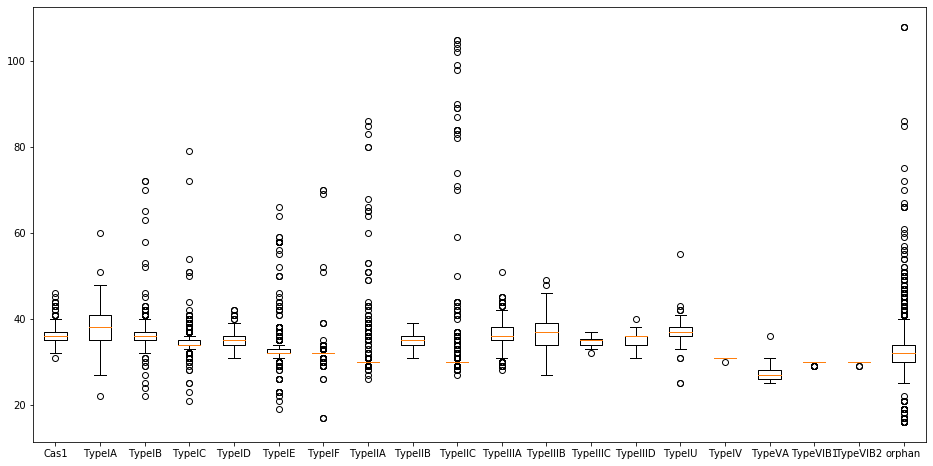

In [7]:
%matplotlib inline

# plot length for each type
labels = sorted(spacer_data_info["test"].keys())
data = []

for key in sorted(spacer_data_info["test"].keys()):
    data.append(spacer_data_info["test"][key]["Length"])

fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()
# fig1.savefig('CRISPR_DR_PublicParis_boxplot_length.pdf')
# fig1.savefig('CRISPR_DR_PublicParis_boxplot_length.png')

In [8]:
spacer_data_info["test"]["TypeIA"].keys()

dict_keys(['ID', 'Seq', 'Int_Seq', 'Length'])

In [9]:
all_sequence_no = spacer_data_info["train"]["Int_Seq"]

In [10]:
# numpy array of sequences of a fixed length
# define dimension of features
no_dim_features = 50
# define numpy array with dimension
all_sequence_no_dim = np.empty(shape=(len(all_sequence_no),no_dim_features))

print(all_sequence_no_dim.shape)

for n in range(len(all_sequence_no)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in all_sequence_no[n]]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= no_dim_features:
        all_sequence_no_dim[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim[n]=sequence_digits[0:no_dim_features]   

(221397, 50)


In [11]:
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
x_train = min_max_scaler.fit_transform(all_sequence_no_dim)

In [12]:
all_sequence_no_test=[]
for key in spacer_data_info["test"].keys():
    all_sequence_no_test.extend(spacer_data_info["test"][key]["Int_Seq"])
    print(key)
#print(all_sequence_no_test)

TypeIB
TypeIF
TypeVA
orphan
TypeIC
TypeIIID
TypeIIC
TypeIIIA
TypeIU
TypeIIB
TypeVIB1
TypeIIIB
TypeIV
Cas1
TypeVIB2
TypeIIA
TypeIIIC
TypeID
TypeIA
TypeIE


In [13]:
# numpy array of sequences of a fixed length
# define dimension of features
no_dim_features = 50
# define numpy array with dimension
all_sequence_no_dim_test = np.empty(shape=(len(all_sequence_no_test),no_dim_features))

print(all_sequence_no_dim_test.shape)

for n in range(len(all_sequence_no_test)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in all_sequence_no_test[n]]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= no_dim_features:
        all_sequence_no_dim_test[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim_test[n]=sequence_digits[0:no_dim_features]   

(63095, 50)


In [14]:
all_sequence_no_dim_test

array([[2., 4., 2., ..., 0., 0., 0.],
       [1., 2., 1., ..., 0., 0., 0.],
       [2., 1., 4., ..., 0., 0., 0.],
       ...,
       [1., 3., 1., ..., 0., 0., 0.],
       [3., 1., 3., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.]])

In [15]:
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
x_test = min_max_scaler.fit_transform(all_sequence_no_dim_test)

# Step 2: Autoencoder model
- use Keras to create, compile, fit autoencoder model

In [16]:
# Setseed
def reproduce(seed_number):
    import random
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_number)
    random.seed(seed_number)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.set_random_seed(seed_number)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    tf.keras.backend.set_session(sess)
reproduce(2020)

#plot original data, reconstructed data, residuals
def plot_reconstruction(data_norm, data_dec):
    fig = plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    cmap = cm.get_cmap('PuRd', 5)
    
    ax1 = plt.imshow(data_norm, cmap=cmap, aspect="auto", vmin=0, vmax=1)
    plt.tick_params(labelsize=20)
    cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0:NA', '0.25:T', '0.5:A', '0.75:G', '1:C'])
    cbar.ax.tick_params(labelsize=20)
    plt.title('Original data', fontsize=25)
    plt.subplot(3,1,2)
    
    ax2 = plt.imshow(data_dec, cmap=cmap, aspect="auto", vmin=0, vmax=1)
    plt.tick_params(labelsize=20)
    cbar = plt.colorbar(ticks=[0,0.25,0.5,0.75,1])
    cbar.ax.set_yticklabels(['0:NA', '0.25:T', '0.5:A', '0.75:G', '1:C'])
    cbar.ax.tick_params(labelsize=20)
    plt.title('Reconstructed data', fontsize=25)
    plt.subplot(3,1,3)
    
    ax3 = plt.imshow(data_norm-data_dec, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
    plt.tick_params(labelsize=20)
    cbar = plt.colorbar(ax3)
    cbar.ax.tick_params(labelsize=20)
    plt.title('Residuals', fontsize=25)

    plt.show()
#    fig.savefig('CRISPR_DR_PublicParis_Reconstructed.pdf')
#    fig.savefig('CRISPR_DR_PublicParis_Reconstructed.png')
    # print residual values
    print(sum(abs(data_norm-data_dec)))
    
#plot training history
def plot_history(autoencoder):
    fig = plt.figure(figsize=(6,4))
    plt.plot(autoencoder.history.history['loss'])
#    plt.plot(autoencoder.history.history['val_loss'])
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss function', fontsize=12)
    plt.legend(['Training set'], fontsize=12)
    plt.show()
#    fig.savefig('CRISPR_DR_PublicParis_history.pdf')
#    fig.savefig('CRISPR_DR_PublicParis_history.png')

In [17]:
#set dimensions of input and hidden layer
input_dim = no_dim_features
# intermediate_1 = int(input_dim/2)
# intermediate_2 = int(intermediate_1/2)
# intermediate_3 = int(intermediate_2/2)
latent_dim = 2

# Keras API default: weight=glorot_uniform, bias=zeros
input_data = Input(shape=(input_dim,))
#input_data_masked = Masking(mask_value=0)(input_data)

#encode the input with a dense layer
encoded_1 = Dense(latent_dim, activation='relu')(input_data)
#encoded_1 = Dense(latent_dim, activation='relu')(input_data_masked)
# encoded_2 = Dense(intermediate_2, activation='sigmoid')(encoded_1)
# encoded_3 = Dense(intermediate_3, activation='sigmoid')(encoded_2)
# encoded_4 = Dense(latent_dim, activation='sigmoid')(encoded_3)

#decode the encoded input to its reconstruction
# decoded_1 = Dense(intermediate_3, activation='sigmoid')(encoded_4)
# decoded_2 = Dense(intermediate_2, activation='sigmoid')(decoded_1)
# decoded_3 = Dense(intermediate_1, activation='sigmoid')(decoded_2)
decoded_1 = Dense(input_dim, activation='sigmoid')(encoded_1)

#autoencoder_2 maps the input to the output
autoencoder_1 = Model(input_data, decoded_1)

#encoder_2 maps the input to the latent representation
encoder_1 = Model(input_data, encoded_1)

#compile the model and set the desired optimizer and loss function
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

autoencoder_1.compile(optimizer=adam, loss='mean_squared_error')
autoencoder_1.summary()
autoencoder_1.fit(x_train, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                150       
Total params: 252
Trainable params: 252
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
221397/221397 [==============================] - 1s 4us/step - loss: 0.1361A: 0s - loss
Epoch 2/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.1233
Epoch 3/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0902
Epoch 4/1

221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 76/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 77/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 78/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 79/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538A: 0s - loss
Epoch 80/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 81/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 82/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 83/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 84/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 85/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0538
Epoch 86/100

221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 166/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 167/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 168/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 169/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 170/1000
221397/221397 [==============================] - 1s 2us/step - loss: 0.0537
Epoch 171/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 172/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 173/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 174/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 175/1000
221397/221397 [==============================] - 1s 2us/step - loss: 0.0537
Epoch 176/1000

221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 255/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 256/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 257/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 258/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 259/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 260/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 261/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 262/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 263/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 264/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 265/1000

221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 344/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537A: 0s - loss: 0.05
Epoch 345/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 346/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 347/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 348/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 349/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 350/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 351/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 352/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0537
Epoch 353/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0

221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 433/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 434/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 435/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 436/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 437/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 438/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 439/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 440/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 441/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 442/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 443/1000

Epoch 522/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 523/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 524/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 525/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 526/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 527/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 528/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 529/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 530/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 531/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 532/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536

221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 612/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 613/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 614/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 615/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 616/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 617/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 618/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 619/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 620/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 621/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 622/1000

221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 701/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 702/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 703/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 704/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 705/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 706/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 707/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 708/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 709/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 710/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0536
Epoch 711/1000

Epoch 789/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 790/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 791/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 792/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535A: 0s - loss: 0.053
Epoch 793/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 794/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 795/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 796/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 797/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535A: 0s - loss:
Epoch 798/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 799/1000
221397/221397 [============================

Epoch 878/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 879/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 880/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 881/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 882/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 883/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 884/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 885/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 886/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 887/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 888/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535

221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 968/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 969/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 970/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 971/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 972/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 973/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 974/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 975/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 976/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 977/1000
221397/221397 [==============================] - 1s 3us/step - loss: 0.0535
Epoch 978/1000

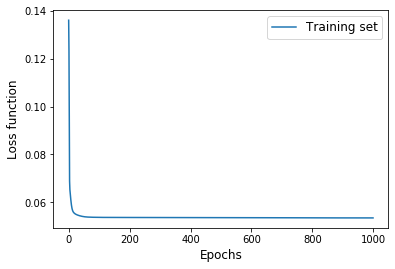

In [18]:
plot_history(autoencoder_1)

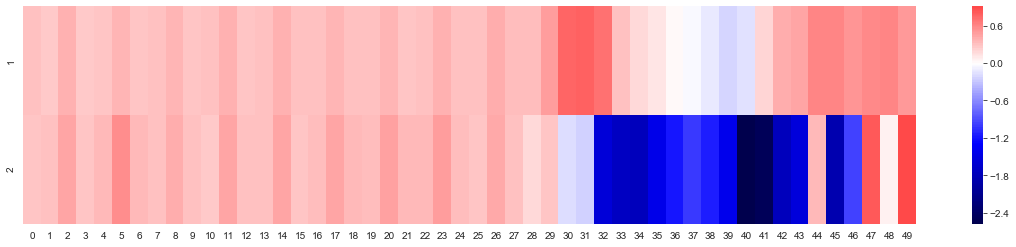

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#get the weights of the hidden layer
weights=autoencoder_1.layers[1].get_weights()
#visualize the weights
fig = plt.figure(figsize=(20,4))
y_axis_labels = [1,2]
sns.heatmap(data=transpose(weights[0]), yticklabels=y_axis_labels, cmap='seismic', center=0)
plt.show()
# fig.savefig('CRISPR_DR_PublicParis_weights.pdf')
# fig.savefig('CRISPR_DR_PublicParis_weights.png')

In [20]:
# encoder input into latent dimensions
x_enc_1 = encoder_1.predict(x_test, batch_size=256)

In [21]:
# save results into a dataframe
labels = []
lengths = []
IDs = []
seqs = []

for key in spacer_data_info["test"].keys():
    IDs.extend(spacer_data_info["test"][key]["ID"])
    lengths.extend(spacer_data_info["test"][key]["Length"])
    seqs.extend(spacer_data_info["test"][key]["Seq"])
    labels.extend([key] * len(spacer_data_info["test"][key]["ID"]))

res_df = pd.DataFrame()
res_df["latent_1"] = x_enc_1[:, 0]
res_df["latent_2"] = x_enc_1[:, 1]
res_df["ID"] = IDs
res_df["label"] = labels
res_df["length"] = lengths
res_df["seq"] = seqs

In [22]:
res_df

,latent_1,latent_2,ID,label,length,seq
0,4.224071,2.700356,CP012098.1,TypeIB,37,ACAATCAGGCGTAATCATTTCCAGTAACTCAATAGCA
1,3.186589,2.673439,CP012098.1,TypeIB,36,TATATTCTTCTATGAAAGTATTATCATCACTGAAAA
2,4.074392,1.857461,CP012098.1,TypeIB,36,ATCGTTGTAGTTAACGTATTAGATCCGGCAAAACAC
3,4.045923,2.137410,CP012098.1,TypeIB,38,TTGTTCAAACTCCTTTCTTTCTTCCTCGTCTTCATCAT
4,4.420208,2.047837,CP012098.1,TypeIB,38,GTAAAAGCAGGCGGTTATGGAATCGAAGCTGTGGAAAA
5,4.022243,2.879080,CP012098.1,TypeIB,36,TCTATTGTCATTTTTCCGCAATACTCTTTCCAGTTC
6,2.773103,3.611585,CP012098.1,TypeIB,36,GAACTACAGACACTTTTTTCTATTATTGGTTATAAT
7,4.537265,2.883670,CP012098.1,TypeIB,38,CAAAAAGCACAAATAAATACACGGTATACACAGTAAAT
8,4.419269,0.000000,CP012098.1,TypeIB,53,ATAAATTTGGGGGATATTATAAAAAACATGAAATGAAAACAGAATT...
9,3.596551,4.791135,CP012098.1,TypeIB,34,CTTTCTTCGTCGATGATCTTCGTTGTCTTGATGA


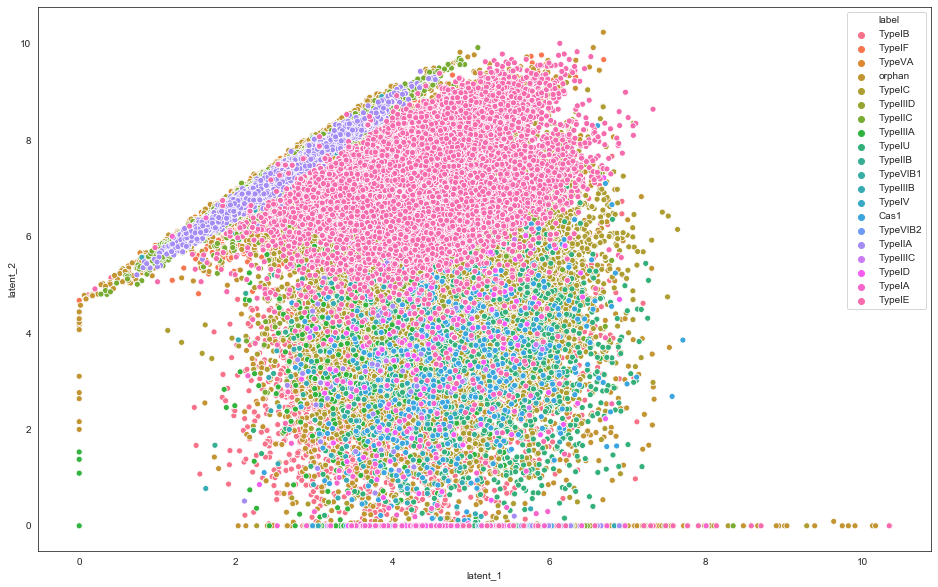

In [23]:
# plot test sequences by labels
plt.figure(figsize=(16,10))
sns.scatterplot("latent_1", "latent_2", hue="label", data=res_df)
plt.show()

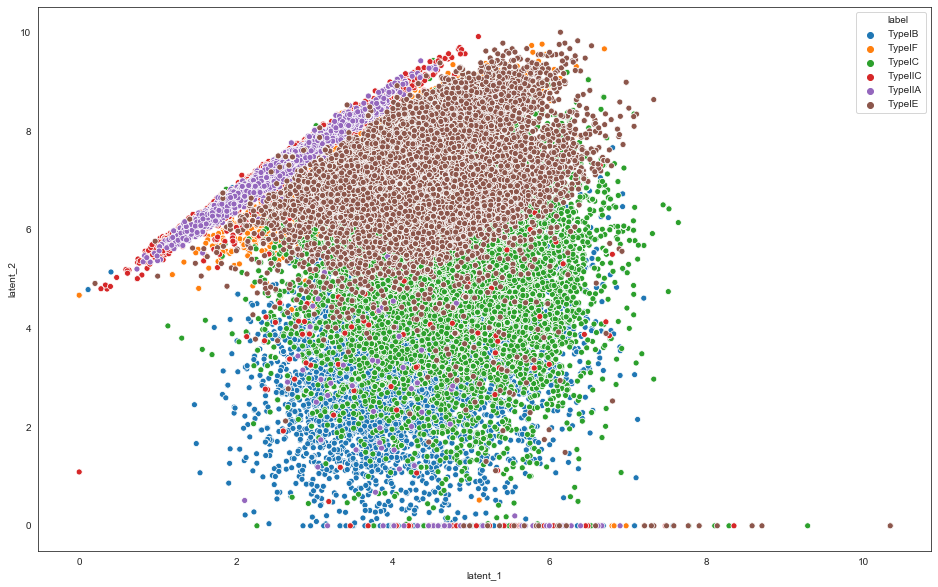

In [24]:
# plot only major test sequences by labels
Type = ['TypeIF','TypeIE','TypeIB','TypeIC','TypeIIC','TypeIIA']
df_major = res_df[res_df.label.isin(Type)]
plt.figure(figsize=(16,10))
sns.scatterplot(x = "latent_1", y = "latent_2", hue="label", data=df_major)
plt.show()

# Step 3: Clustering algorithm 
- use GMM, k-means clustering in latent dimension

In [25]:
# Gaussian Mixture Model (GMM)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 10)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(x_enc_1)
        bic.append(gmm.bic(x_enc_1))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

/Users/jinenstar/.pyenv/versions/3.7.3/envs/Project_AE_genes/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:625: RuntimeWarning: invalid value encountered in multiply
  inertia = (mindist * sample_weight).sum()
/Users/jinenstar/.pyenv/versions/3.7.3/envs/Project_AE_genes/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/jinenstar/.pyenv/versions/3.7.3/envs/Project_AE_genes/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/jinenstar/.pyenv/versions/3.7.3/envs/Project_AE_genes/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:625: RuntimeWarning: invalid value encountered in multiply
  inertia = (mindist * sample_weight).sum()
/Users/jinenstar/.pyenv/versions/3.7.3/envs/Project_AE_genes/lib/python3.7/site-packages/numpy/core/_methods.py:36: Runt

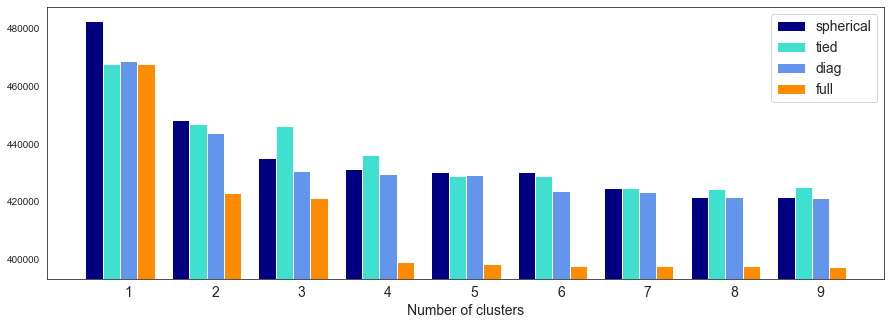

In [26]:
# Plot the BIC scores
fig = plt.figure(figsize=(15, 5))
#spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range, fontsize=14)
plt.ylim([bic.min() * 1.05 - .05 * bic.max(), bic.max() * 1.01])
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.xlabel('Number of clusters', fontsize=14)
plt.legend([b[0] for b in bars], cv_types, fontsize=14)

#fig.savefig('CRISPR_DR_PublicParis_GMM_BIC.pdf')

In [27]:
# winner as component = 7
n_clusters=7
Gmix = GaussianMixture(n_clusters, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10).fit_predict(x_enc_1)

In [28]:
Gmix[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 6, 1, 1, 0, 1, 1, 1, 1, 1, 6, 1, 1,
       1, 1, 1, 1, 1, 2, 3, 6, 1, 1, 6, 1, 6, 3, 6, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 2, 6, 1, 6, 6, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 6, 3, 6, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 1])

In [29]:
res_df["Gmix"] = Gmix

In [30]:
res_df

,latent_1,latent_2,ID,label,length,seq,Gmix
0,4.224071,2.700356,CP012098.1,TypeIB,37,ACAATCAGGCGTAATCATTTCCAGTAACTCAATAGCA,1
1,3.186589,2.673439,CP012098.1,TypeIB,36,TATATTCTTCTATGAAAGTATTATCATCACTGAAAA,1
2,4.074392,1.857461,CP012098.1,TypeIB,36,ATCGTTGTAGTTAACGTATTAGATCCGGCAAAACAC,1
3,4.045923,2.137410,CP012098.1,TypeIB,38,TTGTTCAAACTCCTTTCTTTCTTCCTCGTCTTCATCAT,1
4,4.420208,2.047837,CP012098.1,TypeIB,38,GTAAAAGCAGGCGGTTATGGAATCGAAGCTGTGGAAAA,1
5,4.022243,2.879080,CP012098.1,TypeIB,36,TCTATTGTCATTTTTCCGCAATACTCTTTCCAGTTC,1
6,2.773103,3.611585,CP012098.1,TypeIB,36,GAACTACAGACACTTTTTTCTATTATTGGTTATAAT,1
7,4.537265,2.883670,CP012098.1,TypeIB,38,CAAAAAGCACAAATAAATACACGGTATACACAGTAAAT,1
8,4.419269,0.000000,CP012098.1,TypeIB,53,ATAAATTTGGGGGATATTATAAAAAACATGAAATGAAAACAGAATT...,6
9,3.596551,4.791135,CP012098.1,TypeIB,34,CTTTCTTCGTCGATGATCTTCGTTGTCTTGATGA,1


In [31]:
# save test sequences to .fa files by cluster
# for n in range(n_clusters):
#     cluster = res_df.loc[res_df['Gmix']==n]
#     with open('PublicCRISPR_spacers_autoencoder' + str(n) + '.fa', 'w') as f:
#         for i in range(len(cluster)):
#             f.write(">" + str(cluster["ID"].iloc[i]) + "\n" + str(cluster["label"].iloc[i]) + "\n")

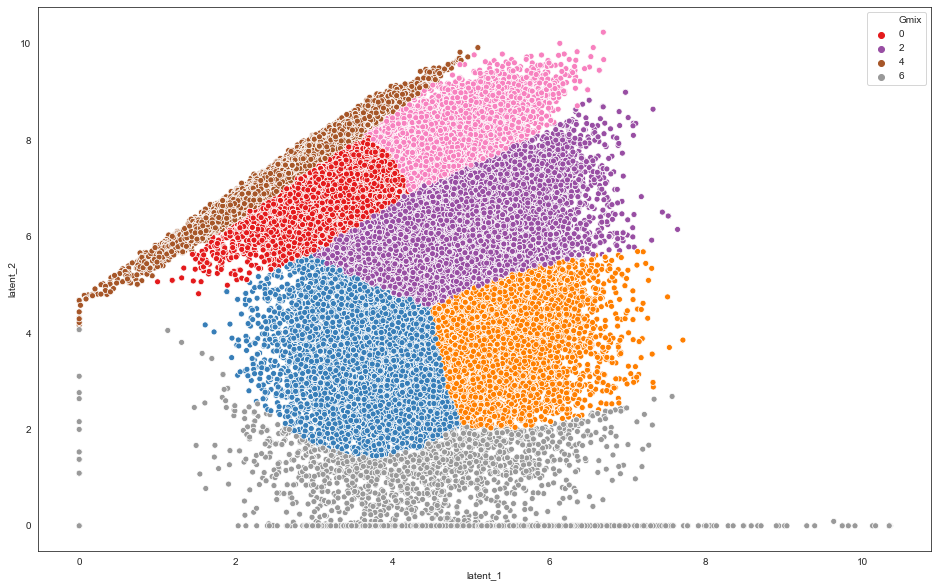

In [32]:
# plot test sequences by cluster
plt.figure(figsize=(16,10))
sns.scatterplot("latent_1", "latent_2", hue="Gmix", data=res_df, palette="Set1")
plt.show()

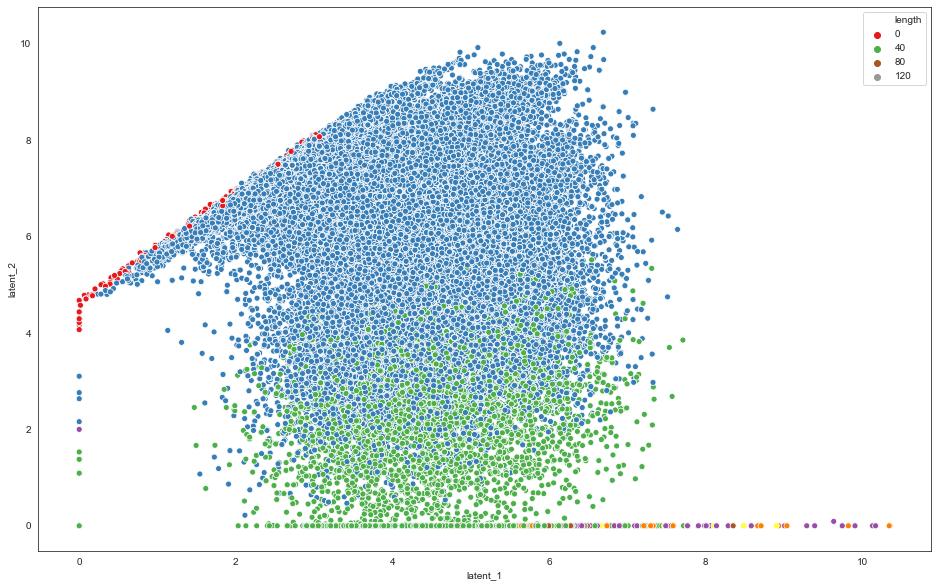

In [33]:
# plot test sequences by length
plt.figure(figsize=(16,10))
sns.scatterplot("latent_1", "latent_2", hue="length", data=res_df, palette="Set1")
plt.show()

In [34]:
#calculate mean and stdev of length by cluster
length_cluster = {}
for n in range(n_clusters):
    dat_cluster = res_df.loc[res_df['Gmix']==n]
    length_cluster.update({n:(calculate_cluster_mean(dat_cluster),calculate_cluster_stdev(dat_cluster))})
length_cluster

{0: (32.01397501156872, 0.4069110680416664),
 1: (35.62362388291672, 1.2288759662321094),
 2: (33.72777090330564, 0.8239076797635707),
 3: (35.61832586978987, 1.0764258118495253),
 4: (29.73315868263473, 1.099704643727282),
 5: (32.05309432351686, 0.3360649834581904),
 6: (40.13605728727885, 7.551677657234401)}

In [35]:
#calculate GC content by cluster
GC_content_cluster = {}
for n in range(n_clusters):
    dat_cluster = res_df.loc[res_df['Gmix']==n]
    dat_cluster_seq = dat_cluster["seq"].tolist()
    GC_content_cluster.update({n:calculate_GC_content(dat_cluster_seq)})
GC_content_cluster

{0: (0.6958436915879691, 0.2502166853023966),
 1: (0.5562571898490811, 0.22395407154942187),
 2: (1.3960171549928488, 0.7636336025914784),
 3: (1.5441150051049042, 0.6389488223120795),
 4: (0.7718818302721129, 0.5195322953138384),
 5: (1.5768505900531702, 0.6643125482749882),
 6: (1.0117511213904968, 0.7042360311192357)}

In [36]:
#calculate Entropy by cluster
Shannon_E_cluster = {}
for n in range(n_clusters):
    dat_cluster = res_df.loc[res_df['Gmix']==n]
    dat_cluster_seq = dat_cluster["seq"].tolist()
    Shannon_E_cluster.update({n:calculate_Shannon_E(dat_cluster_seq)})
Shannon_E_cluster

{0: (0.05872698929677739, 0.003312096665880962),
 1: (0.051442487025981046, 0.003630153785722064),
 2: (0.05624483313584494, 0.002811809708409659),
 3: (0.05346686912718318, 0.0027545155390832515),
 4: (0.06232255457275415, 0.005322272785209526),
 5: (0.05910225403256319, 0.0027666497559623525),
 6: (0.0468651148545384, 0.007109518350198457)}